In [1]:
import sys 
import numpy as np
import settings as s
import matplotlib.pyplot as plt 
import importlib
importlib.reload(s)
from cupyx.profiler import benchmark
import h5py
import os
import re
import time
import datetime
from datetime import datetime
import pandas as pd
import math
from scipy.optimize import curve_fit

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

dataDir         = '/RunData/run1p4_5_10_23/run1p4/'
filename        = 'packedh5.hdf5'
databaseFile    = 'database.txt'

databaseDf      = pd.read_csv(dataDir + databaseFile)

totalAcqs       = databaseDf['ACQ NUM'].to_numpy()[-1]

freqs       = np.linspace(0, 400e6, 2**23, dtype=np.float64)


termIdx     = databaseDf[databaseDf['SWITCH_POS']==1]['ACQ NUM'].to_numpy()
antIdx      = databaseDf[databaseDf['SWITCH_POS']==0]['ACQ NUM'].to_numpy()


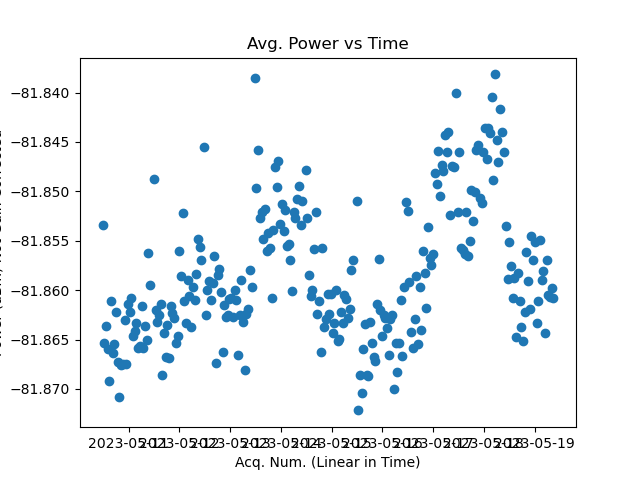

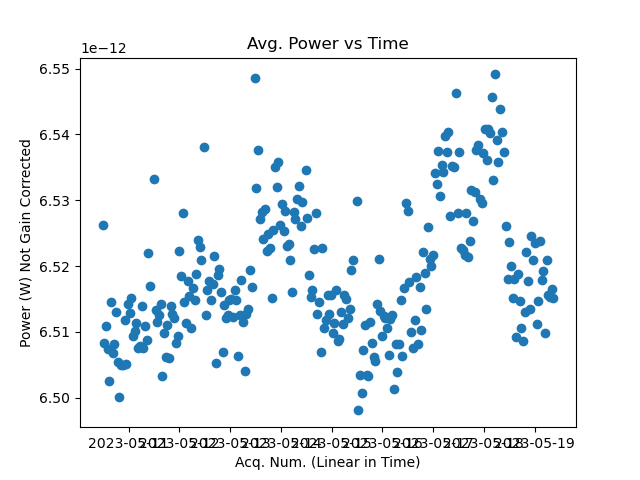

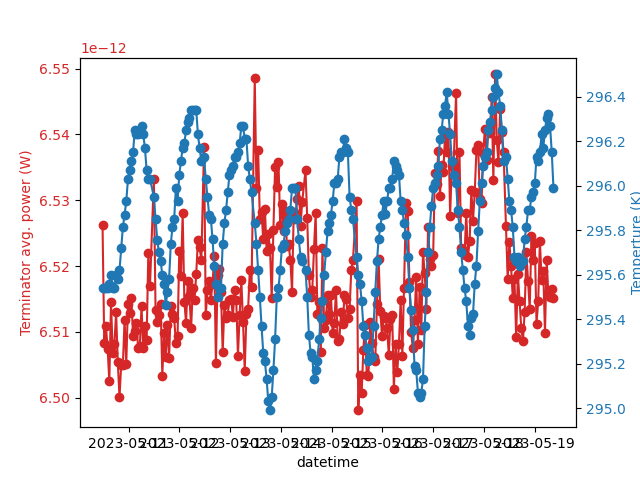

Text(0, 0.5, 'Temperture (K)')

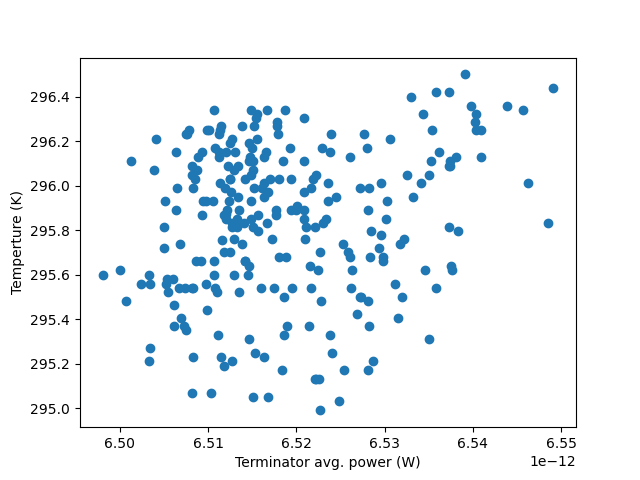

In [6]:
#terminator vs time
if 1:
    f               = h5py.File(dataDir + filename, 'r')
    avgPow          = []
    powDatetimes    = []
    for i in (termIdx):
        avgPow.append(f['spec_W_chB'][freq2Idx(50e6, freqs):freq2Idx(300e6, freqs):10000, i].mean())
        powDatetime = datetime.strptime(databaseDf['DATETIME'][i], ' %Y-%m-%d %H:%M:%S.%f')
        powDatetimes.append(powDatetime)
    f.close()

temp            = databaseDf[databaseDf['SWITCH_POS']==1]['TEMP'].to_numpy()


plt.close('all')
plt.figure()
plt.title('Avg. Power vs Time')
plt.scatter(powDatetimes,10*np.log10((avgPow) ) + 30)
plt.xlabel('Acq. Num. (Linear in Time)')
plt.ylabel('Power (dBm) Not Gain Corrected')
plt.show()

plt.figure()
plt.title('Avg. Power vs Time')
plt.scatter(powDatetimes, avgPow)
plt.xlabel('Acq. Num. (Linear in Time)')
plt.ylabel('Power (W) Not Gain Corrected')
plt.show()



plt.title('Avg. Power vs Time')
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('datetime')
ax1.set_ylabel('Terminator avg. power (W)', color=color)
ax1.plot(powDatetimes, avgPow, color=color)
ax1.scatter(powDatetimes, avgPow, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Temperture (K)', color=color)  # we already handled the x-label with ax1
ax2.plot(powDatetimes, temp, color=color)
ax2.scatter(powDatetimes, temp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

plt.figure()
plt.scatter(avgPow, temp)
plt.xlabel('Terminator avg. power (W)')
plt.ylabel('Temperture (K)')

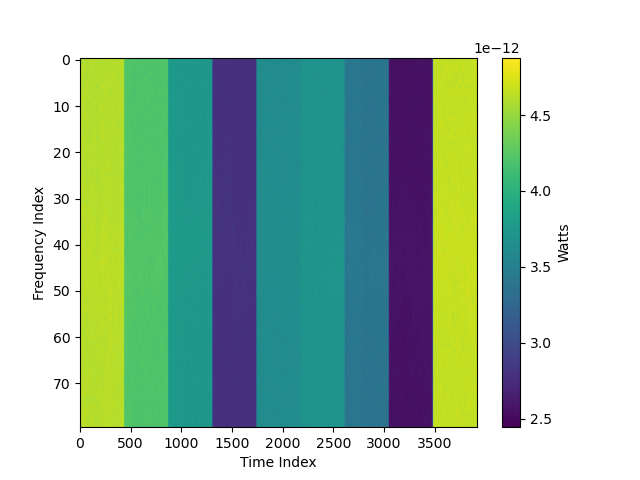

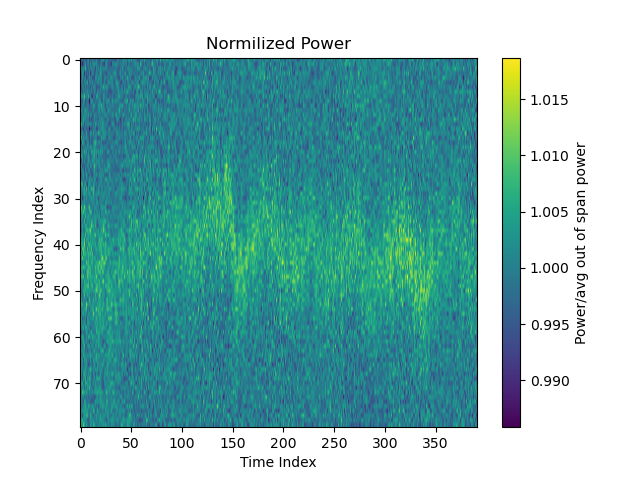

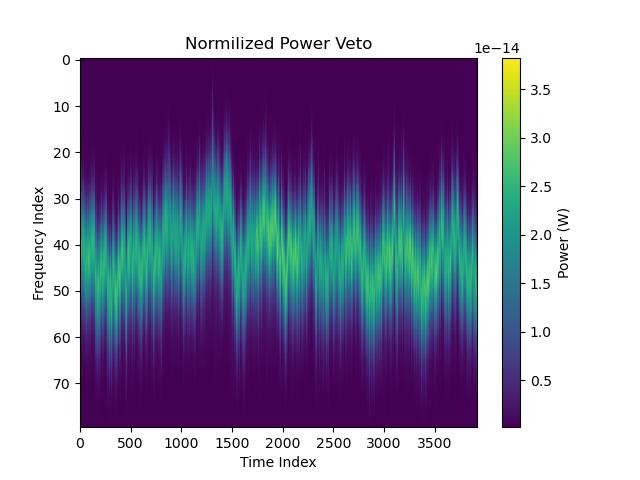

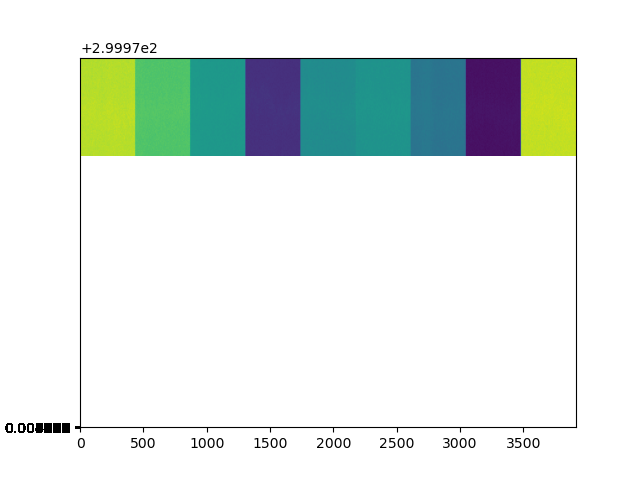

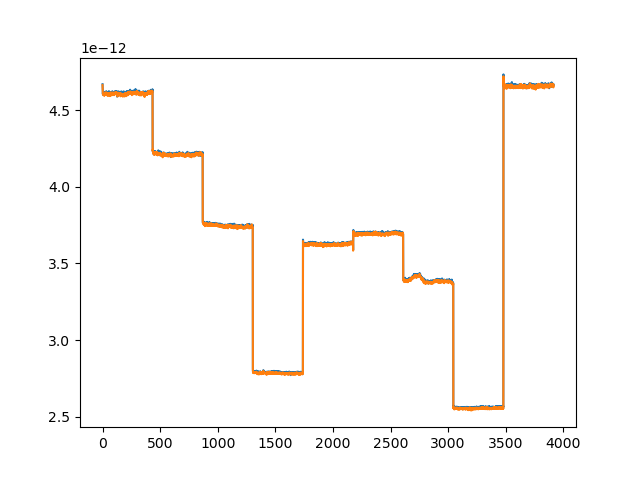

In [3]:
startFreq       = 299.973e6
stopFreq        = 299.9775e6
startIdx        = freq2Idx(startFreq, freqs) +5
stopIdx         = freq2Idx(stopFreq, freqs) -10
if 1:
    f                   = h5py.File(dataDir + filename, 'r')
    candidateSubSpan    = f['spec_W_chB'][startIdx:stopIdx, antIdx]
    normilizePowerUp    = np.mean(f['spec_W_chB'][stopIdx:stopIdx+50, antIdx], axis = 0)  
    normilizePowerDown  = np.mean(f['spec_W_chB'][startIdx-50:startIdx, antIdx], axis = 0)
    normilizePower      = (normilizePowerUp + normilizePowerDown)/2   

    candidateSubSpanV   = f['spec_W_chA'][startIdx:stopIdx, antIdx]
    normilizePowerUpV   = np.mean(f['spec_W_chB'][stopIdx:stopIdx+50, antIdx], axis = 0)  
    normilizePowerDownV = np.mean(f['spec_W_chB'][startIdx-50:startIdx, antIdx], axis = 0)
    normilizePowerV     = (normilizePowerUp + normilizePowerDown)/2       

    f.close()

def average_time_steps(data, avg_num):
    num_freq_steps, num_time_steps = data.shape
    num_averaged_time_steps = num_time_steps // avg_num
    data_out = np.zeros((num_freq_steps, num_averaged_time_steps))
    
    for i in range(num_averaged_time_steps):
        start_index = i * avg_num
        end_index = start_index + avg_num
        averaged_time_step = np.mean(data[:, start_index:end_index], axis=1)
        data_out[:, i] = averaged_time_step
    
    return data_out

normalizedSubSpan       = np.zeros(candidateSubSpan.shape)
normalizedSubSpanV      = np.zeros(candidateSubSpanV.shape)
for i in range(candidateSubSpan.shape[0]):
    #print((candidateSubSpan[i,:] / normilizePower).shape)
    normalizedSubSpan[i, :] = (candidateSubSpan[i,:] / normilizePower)
    normalizedSubSpanV[i, :] = (candidateSubSpanV[i,:] / normilizePowerV)



plt.close('all')
plt.imshow(candidateSubSpan, aspect='auto')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
cbar = plt.colorbar()
cbar.set_label("Watts")

plt.figure()
plt.title("Normilized Power")
plt.imshow(average_time_steps(normalizedSubSpan, 10), aspect='auto')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
cbar = plt.colorbar()
cbar.set_label("Power/avg out of span power")

plt.figure()
plt.title("Normilized Power Veto")
plt.imshow(average_time_steps(candidateSubSpanV, 1), aspect='auto')
plt.xlabel('Time Index')
plt.ylabel('Frequency Index')
cbar = plt.colorbar()
cbar.set_label("Power (W)")


fig, ax = plt.subplots()
fig = ax.imshow(average_time_steps(candidateSubSpan,1)[:,:], aspect='auto')
ax.set_yticks(np.linspace(startFreq/1e6, stopFreq/1e6, candidateSubSpan.shape[1]))

plt.figure()
plt.plot(candidateSubSpan.mean(axis=0))
plt.plot(normilizePower)
